# Read Data

In [1]:
#read in data
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import pymc as pm
import arviz as az
import os 





def read_data_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_array(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_array(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_array(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_array(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_array(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_array(traj):
    return np.array(traj)



In [2]:
positions, currents, gyro, accel, angles = read_data_json('data/TrajectoriesTorso.json')

In [3]:
from collections import defaultdict

# Calculate the average current for specific position and distance to goal
servos = [0, 1]
avg_current_data = {}
for servo in servos:
    current_data = defaultdict(list)
    x, y, z = [], [], []

    for trajectory in currents.keys():
        # Collect data points for starting position and distance to goal
        current_vals = currents[trajectory][:, servo]
        trajectory_vals = positions[trajectory][:, servo]
        goal_pos = trajectory_vals[-1]
        distances_to_goal = np.round(abs(trajectory_vals - goal_pos), 2)

        for pos, dist_to_goal, curr in zip(trajectory_vals, distances_to_goal, current_vals):
            # Convert to int to avoid float precision issues
            pos = int(pos)
            dist_to_goal = int(dist_to_goal)
            current_data[(pos, dist_to_goal)].append(curr)

    servoname = "NeckTilt" if servo == 0 else "NeckPan"
    # Create a DataFrame for each servo
    avg_current_data[servoname] = pd.DataFrame([
        {'Position': pos, 'DistanceToGoal': dist, 'AvgCurrent': np.mean(np.abs(currents))}
        for (pos, dist), currents in current_data.items()
    ])


In [4]:
avg_current_data["NeckPan"]

Position  DistanceToGoal  AvgCurrent
0          192               6   36.960000
1          191               5   48.414545
2          190               4   30.240000
3          189               3   28.332973
4          188               2   34.160000
...        ...             ...         ...
6621       143              86   20.160000
6622       145              84   23.520000
6623       145              83   20.160000
6624       146              82   28.560000
6625       229              15   43.680000

[6626 rows x 3 columns]

In [5]:
#normalize and standardize data
std_avg_current_data = {}
for servo, data in avg_current_data.items():
    dat = data.copy()
    dat['Position'] = (dat['Position'] - dat['Position'].mean()) / dat['Position'].std()
    dat['DistanceToGoal'] = (dat['DistanceToGoal'] - dat['DistanceToGoal'].mean()) / dat['DistanceToGoal'].std()
    dat['AvgCurrent'] = (dat['AvgCurrent'] - dat['AvgCurrent'].mean()) / dat['AvgCurrent'].std()
    std_avg_current_data[servo] = dat

In [6]:
# Combine the data to a dataframe 
all_data = pd.DataFrame()

for key in positions.keys():
    temp_data = pd.DataFrame()
    temp_data['tilt_pos'] = positions[key][:,0]
    temp_data['pan_pos'] = positions[key][:,1]
    temp_data['tilt_current'] = currents[key][:,0]
    temp_data['pan_current'] = currents[key][:,1]
    temp_data['gyro_x'] = gyro[key][:,0]
    temp_data['gyro_y'] = gyro[key][:,1]
    temp_data['gyro_z'] = gyro[key][:,2]
    temp_data['accel_x'] = accel[key][:,0]
    temp_data['accel_y'] = accel[key][:,1]
    temp_data['accel_z'] = accel[key][:,2]
    temp_data['tilt_distance'] = np.abs(positions[key][:,0] - positions[key][-1,0])
    temp_data['pan_distance'] = np.abs(positions[key][:,1] - positions[key][-1,1])
    all_data = pd.concat([all_data, temp_data], ignore_index=True)



In [7]:
#standardize and normalize data
std_all_data = pd.DataFrame()
for col in all_data.columns:
    std_all_data[col] = (all_data[col] - all_data[col].mean()) / all_data[col].std()


In [8]:
#save as csv
std_all_data.to_csv('data/std_all_data.csv', index=False)
all_data.to_csv('data/all_data.csv', index=False)

# Plot functions

In [9]:
def plot_real_vs_predicted(data, ppc, indep_var='Position'):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive['AvgCurrent'].mean(axis=0)[1]
    avg_current_mean = dat['AvgCurrent'].mean()
    avg_current_std = dat['AvgCurrent'].std()
    predicted_current_raw = predicted_current_mean * avg_current_std + avg_current_mean
    
    if isinstance(indep_var, list):
        fig, axes = plt.subplots(1, len(indep_var), figsize=(15, 6))
        for i, var in enumerate(indep_var):
            axes[i].scatter(data[var], data['AvgCurrent'], alpha=0.5, label='Real Current')
            axes[i].scatter(data[var], predicted_current_raw, alpha=0.5, label='Predicted Current')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Average Current')
            axes[i].legend()
        plt.suptitle('Real vs Predicted Average Current')
    else:
        plt.figure(figsize=(10, 6))
        plt.scatter(data[indep_var], data['AvgCurrent'], alpha=0.5, label='Real Current')
        plt.scatter(data[indep_var], predicted_current_raw, alpha=0.5, label='Predicted Current')
        plt.xlabel(indep_var)
        plt.ylabel('Average Current')
        plt.title('Real vs Predicted Average Current')
        plt.legend()
    plt.show()

In [10]:
#plot function that plots topographic map in 3d of the real vs predicted values
def plot_3d_real_vs_predicted(data, ppc, dep_var=["AvgCurrent", "AvgCurrent"], indep_var=['Position', 'DistanceToGoal'], model_name=''):
    dat = data.copy()
    predicted_current_mean = ppc.posterior_predictive[dep_var[1]].mean(axis=0)[1]
    dep_mean = dat[dep_var[0]].mean()
    dep_std = dat[dep_var[0]].std()
    predicted_current_raw = predicted_current_mean * dep_std + dep_mean
    
    fig = plt.figure(figsize=(20, 6))
    
    # Real Current subplot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(dat[indep_var[0]], dat[indep_var[1]], dat[dep_var[0]], alpha=0.5, label='Real Current')
    ax1.set_xlabel(indep_var[0])
    ax1.set_ylabel(indep_var[1])
    ax1.set_zlabel(dep_var[0])
    ax1.set_title('Real data')
    
    # Predicted Current subplot
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(dat[indep_var[0]], dat[indep_var[1]], predicted_current_raw, alpha=0.5, label='Predicted Current', color='orange')
    ax2.set_xlabel(indep_var[0])
    ax2.set_ylabel(indep_var[1])
    ax2.set_zlabel(dep_var[0])
    ax2.set_title('Model Prediciton')
    
    # Set the same axis limits for both subplots
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_zlim(ax1.get_zlim())
    

    if model_name:
        fig.suptitle('Real vs Predicted current, Model: ' + model_name)
        plt.savefig(f'plots/3d_plot_{model_name}.png')
    else:
        fig.suptitle('Real vs Predicted current')
        plt.savefig('plots/3d_plot_noName.png')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

#plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

# Models on the average current

## Tilt

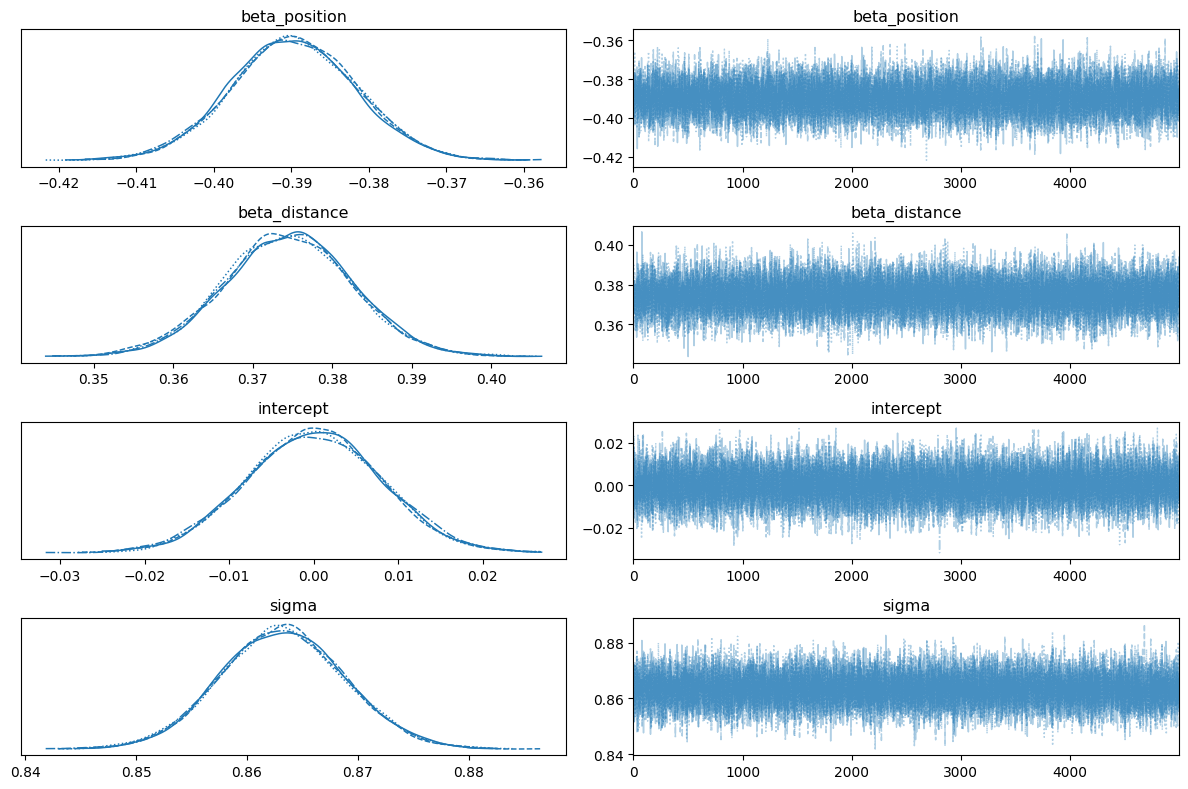

In [12]:
trace_file = 'models/trace_tilt_avg.nc'
# Define the model
with pm.Model() as regression_tilt_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * std_avg_current_data["NeckTilt"]['Position'] + beta_distance * std_avg_current_data['NeckTilt']['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=std_avg_current_data['NeckTilt']['AvgCurrent'])

    if os.path.exists(trace_file):
        trace_tilt = az.from_netcdf(trace_file)
    else:
        trace_tilt = pm.sample(5000, tune=1000, target_accept=0.9)
        az.to_netcdf(trace_tilt, trace_file)
    
 

az.plot_trace(trace_tilt)
plt.tight_layout()
plt.show()

In [13]:
#Posterior Predictive Checks
with regression_tilt_model:
    ppc_tilt = pm.sample_posterior_predictive(trace_tilt)


Sampling: [AvgCurrent]


Output()

## Pan

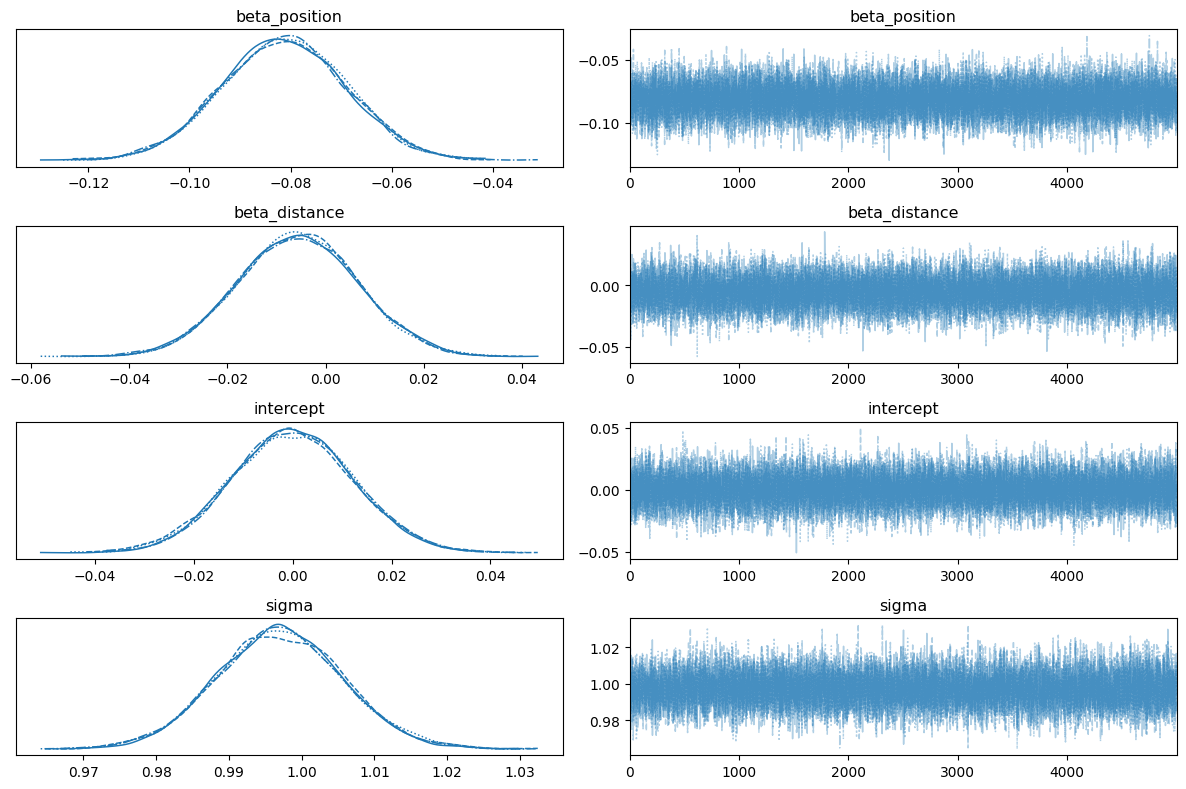

In [14]:
#New model for NeckPan
data = std_avg_current_data["NeckPan"].copy()
trace_file = 'models/trace_pan_avg.nc'

with pm.Model() as regression_pan_model:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept + beta_position * data['Position'] + beta_distance * data['DistanceToGoal']
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_pan = az.from_netcdf(trace_file)
    else:
        trace_pan = pm.sample(5000, tune=1000, target_accept=0.9)
        az.to_netcdf(trace_pan, trace_file)

az.plot_trace(trace_pan)
plt.tight_layout()
plt.show()

In [15]:
#Posterior Predictive Checks
with regression_pan_model:
    ppc_pan = pm.sample_posterior_predictive(trace_pan)


Sampling: [AvgCurrent]


Output()

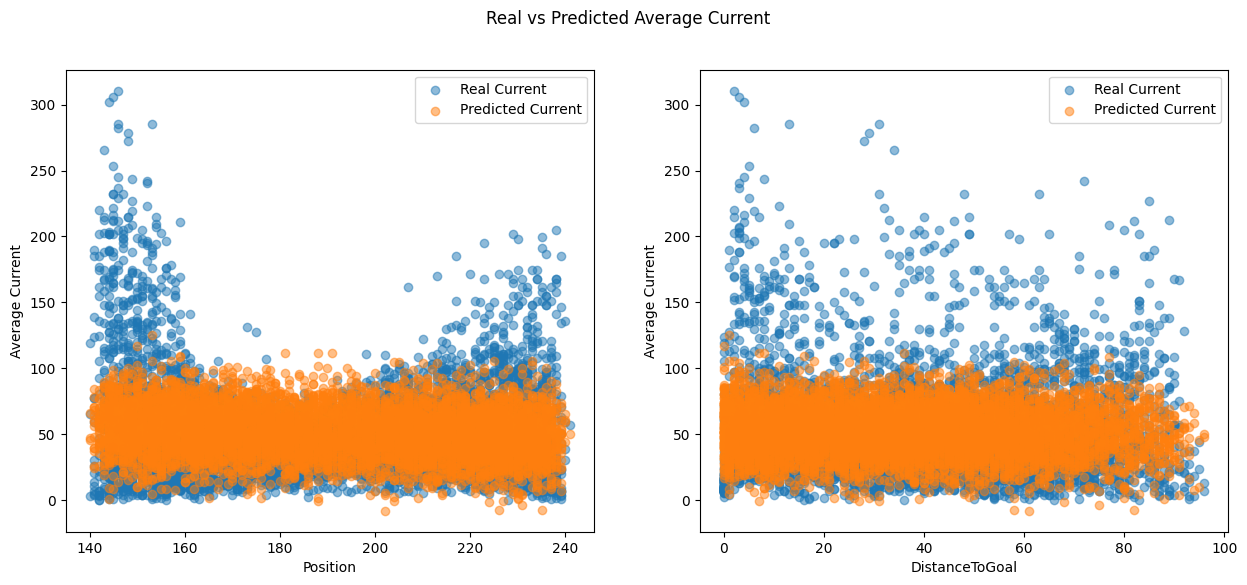

In [16]:

plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan, indep_var=['Position', 'DistanceToGoal'])


## Interaction

In [17]:
#New model for NeckTilit NeackPan Interaction
data = std_avg_current_data["NeckPan"].copy()

trace_file = 'models/trace_tilt_pan_interaction_avg.nc'

with pm.Model() as regression_tilit_pan_model_avg:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position_tilt = pm.Normal('beta_position_tilt', mu=0, sigma=1)
    beta_distance_tilt = pm.Normal('beta_distance_tilt', mu=0, sigma=1)
    beta_position_pan = pm.Normal('beta_position_pan', mu=0, sigma=1)
    beta_distance_pan = pm.Normal('beta_distance_pan', mu=0, sigma=1)

    beta_position_interaction = pm.Normal('beta_position_interaction', mu=0, sigma=1)
    beta_distance_interaction = pm.Normal('beta_distance_interaction', mu=0, sigma=1)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu_tilt = intercept + beta_position_tilt * data['Position'] + beta_distance_tilt * data['DistanceToGoal'] + beta_position_interaction * data['Position'] * data['DistanceToGoal']
    mu_pan = intercept + beta_position_pan * data['Position'] + beta_distance_pan * data['DistanceToGoal'] + beta_distance_interaction * data['Position'] * data['DistanceToGoal']

    # Likelihood (observed data is normally distributed around mu)
    likelihood_tilt = pm.Normal('AvgCurrentTilt', mu=mu_tilt, sigma=sigma, observed=data['AvgCurrent'])
    likelihood_pan = pm.Normal('AvgCurrentPan', mu=mu_pan, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_tilt_pan_interaction = az.from_netcdf(trace_file)
    else:
        trace_tilt_pan_interaction = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan_interaction, trace_file)

## Quadradic models

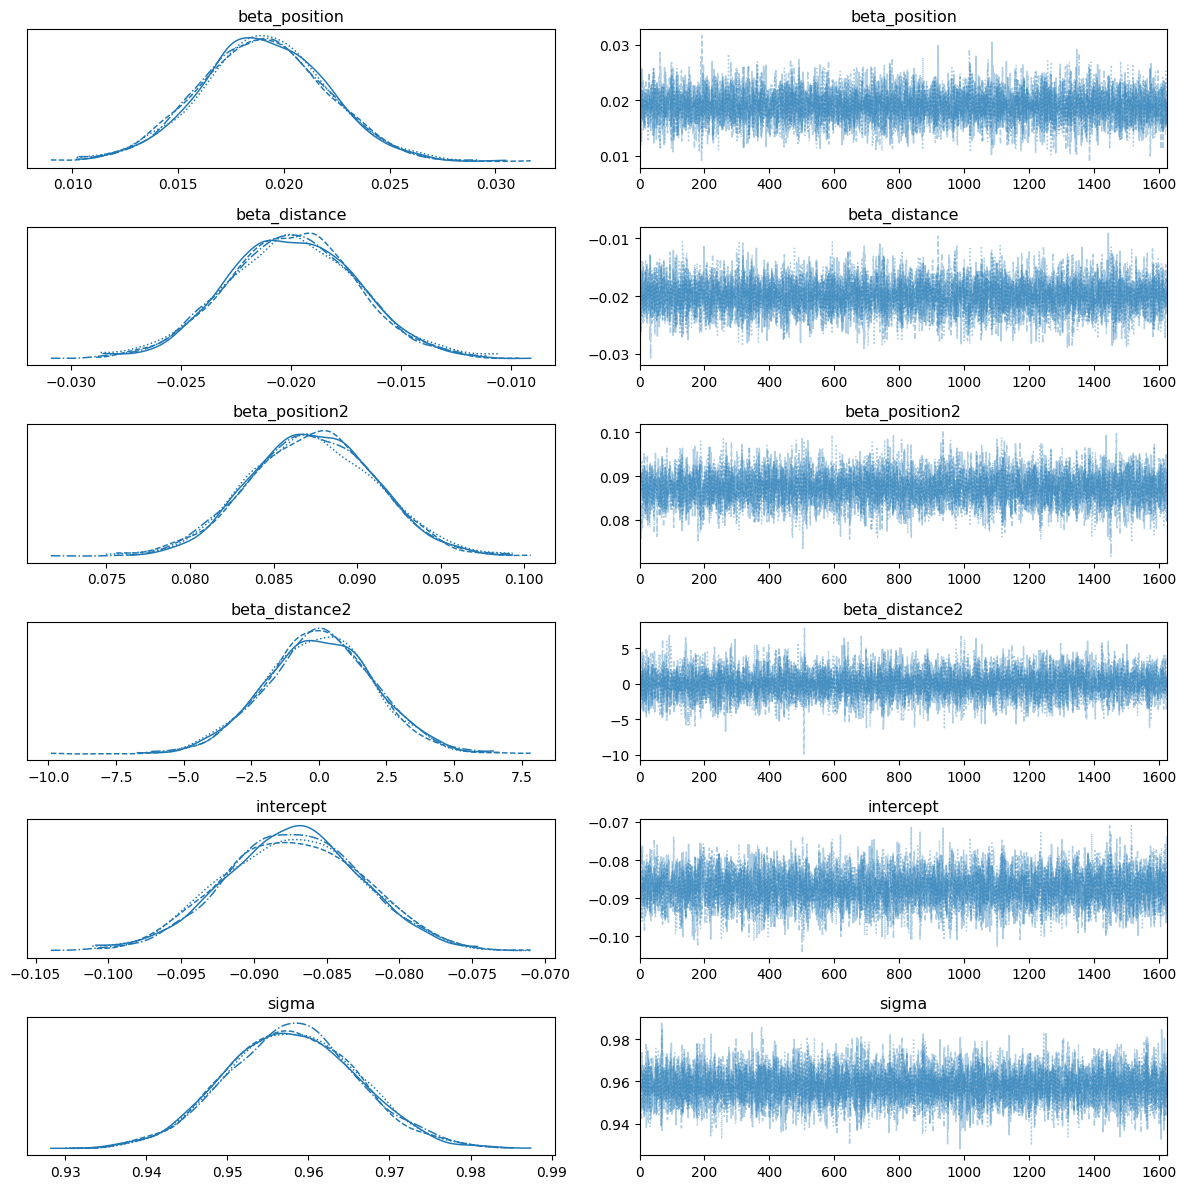

In [18]:
import os
# New polynomial model for NeckPan
data = std_avg_current_data["NeckPan"].copy()

trace_file = 'models/trace_pan_quad_avgcurrent.nc'

with pm.Model() as regression_pan_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)
    

    # Linear model equation
    mu =intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])
    
    if os.path.exists(trace_file):
        trace_pan_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_pan_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        # Save the trace with arviz
        az.to_netcdf(trace_pan_quad, trace_file)


az.plot_trace(trace_pan_quad)
plt.tight_layout()
plt.show()

In [19]:
#Posterior Predictive Checks
with regression_pan_model_quadradic:
    ppc_pan_quad = pm.sample_posterior_predictive(trace_pan_quad)


Sampling: [AvgCurrent]


Output()

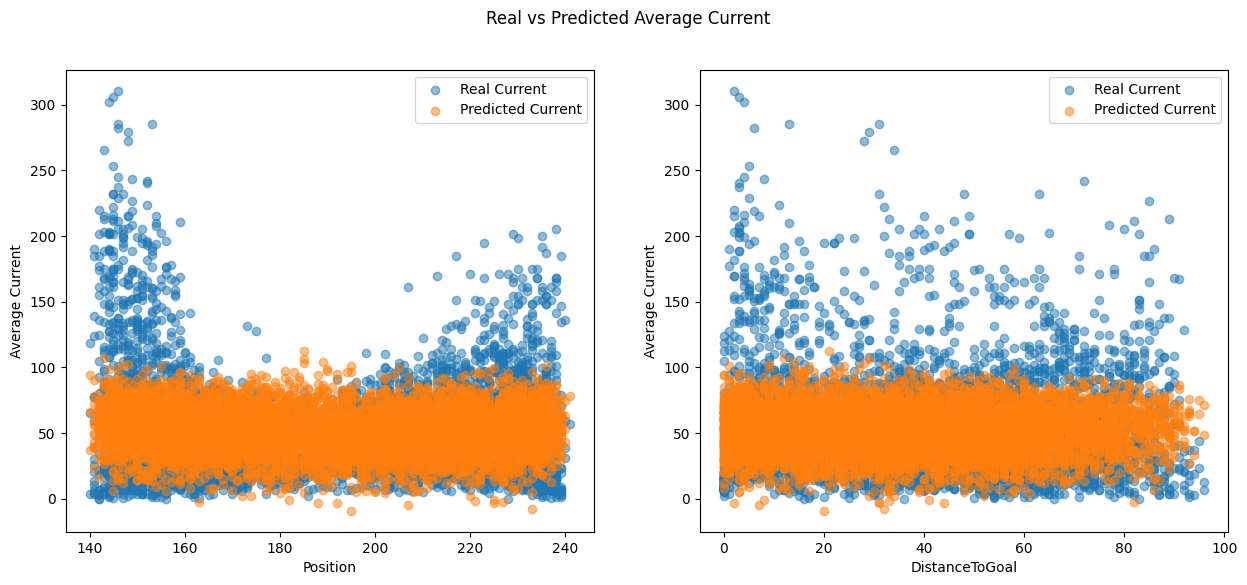

In [20]:
plot_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad, indep_var=['Position', 'DistanceToGoal'])

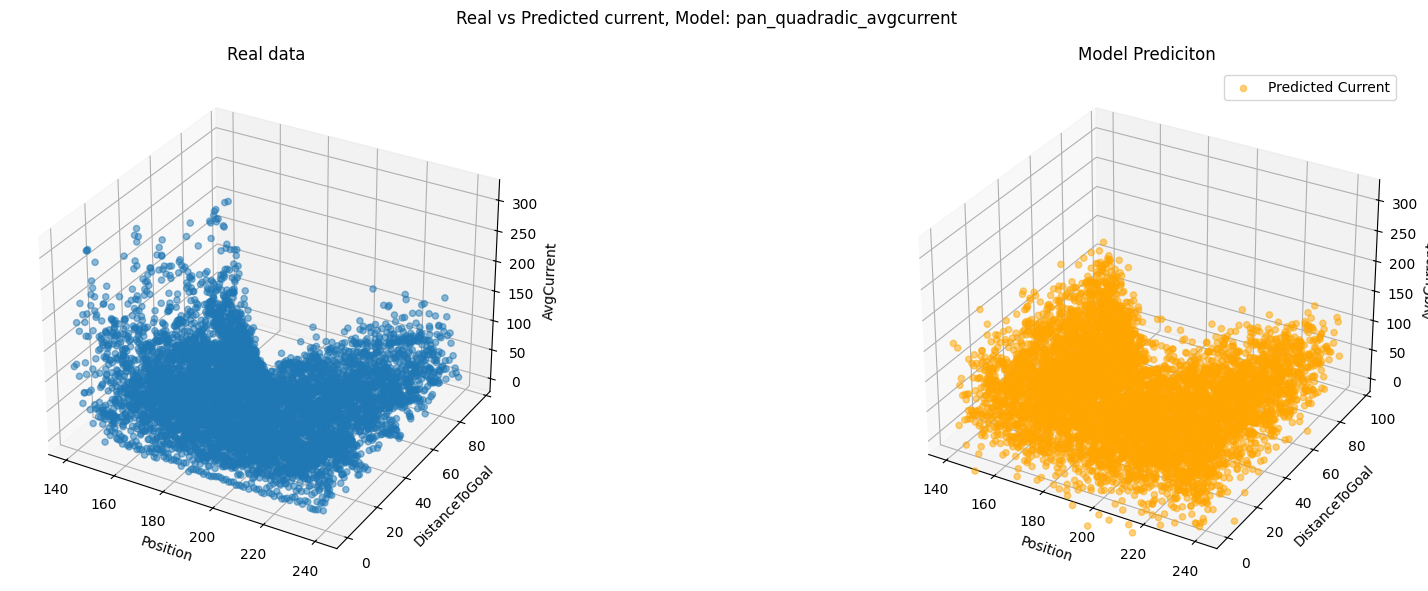

In [21]:
ppc_pan_quad_scaled = ppc_pan_quad.copy()
ppc_pan_quad_scaled.posterior_predictive['AvgCurrent']*=2.5

plot_3d_real_vs_predicted(avg_current_data["NeckPan"], ppc_pan_quad_scaled, indep_var=['Position', 'DistanceToGoal'], model_name='pan_quadradic_avgcurrent')

In [22]:
#Qudratic model for NeckTilt
data = std_avg_current_data["NeckTilt"].copy()

trace_file = 'models/trace_tilt_quad_avgcurrent.nc'

with pm.Model() as regression_tilt_model_quadradic:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['Position'] + beta_distance * data['DistanceToGoal'] + beta_position2 * data['Position']**2
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma, observed=data['AvgCurrent'])

    if os.path.exists(trace_file):
        trace_tilt_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_tilt_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_position, beta_distance, beta_position2, beta_distance2, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.


In [23]:
with regression_tilt_model_quadradic:
    ppc_tilt_quad = pm.sample_posterior_predictive(trace_tilt_quad)

Sampling: [AvgCurrent]


Output()

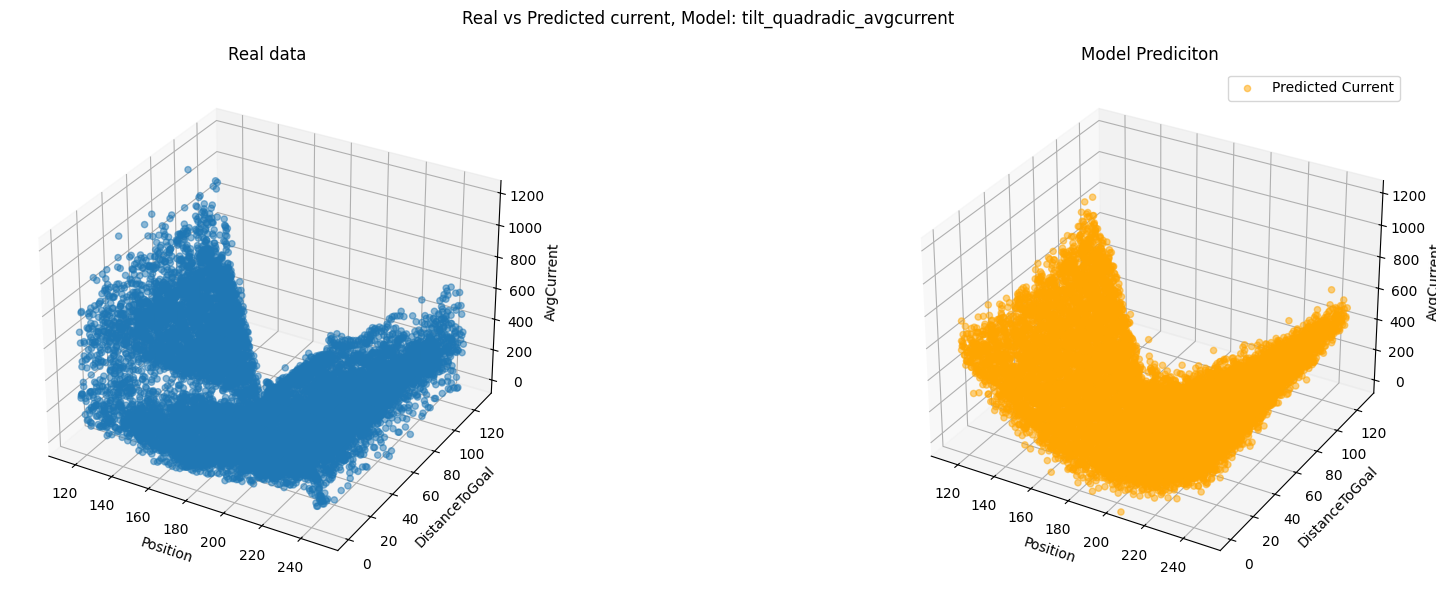

In [24]:
plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad, indep_var=['Position', 'DistanceToGoal'], model_name='tilt_quadradic_avgcurrent')

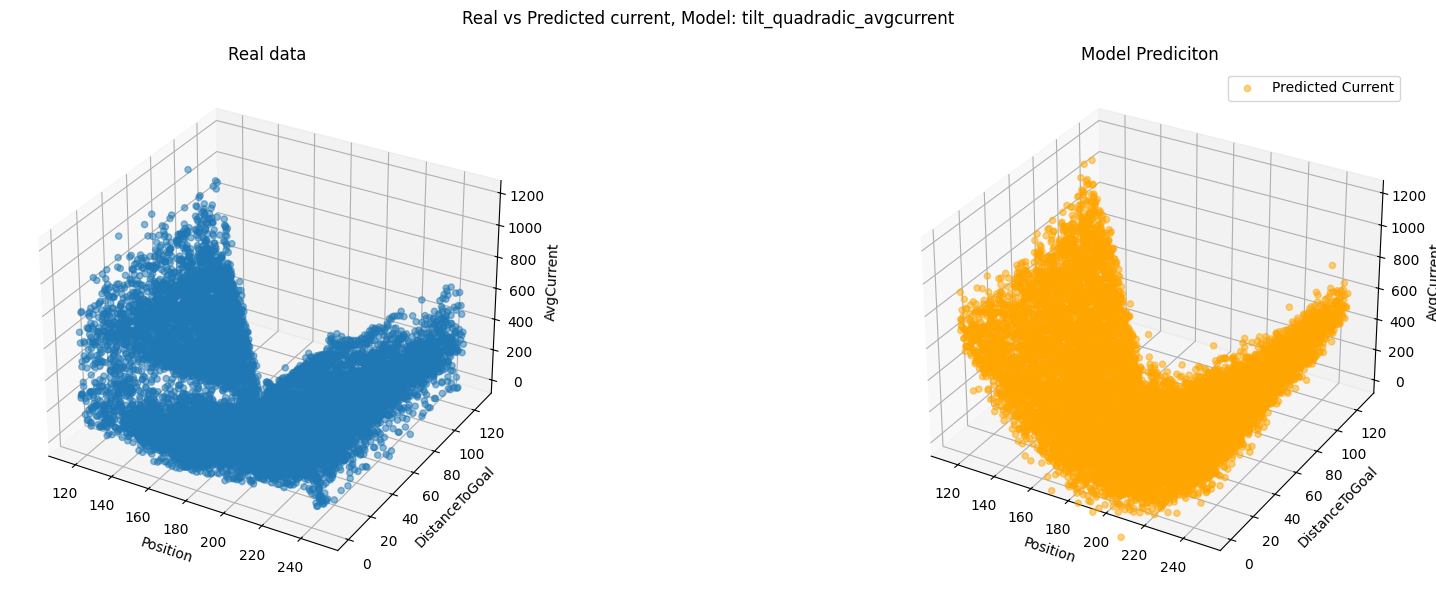

In [25]:
ppc_tilt_quad_scaled = ppc_tilt_quad.copy()
ppc_tilt_quad_scaled.posterior_predictive['AvgCurrent']*=1.4

plot_3d_real_vs_predicted(avg_current_data["NeckTilt"], ppc_tilt_quad_scaled, indep_var=['Position', 'DistanceToGoal'], model_name='tilt_quadradic_avgcurrent')

## Pooling servo model

In [26]:
# Combine NeckPan and NeckTilt data
combined_data = pd.concat([avg_current_data["NeckPan"].assign(Servo='NeckPan'), 
                           avg_current_data["NeckTilt"].assign(Servo='NeckTilt')], 
                          ignore_index=True)

combined_data['Servo'] = combined_data['Servo'].astype('category')
combined_data['Servo_index'] = combined_data['Servo'].cat.codes
combined_data_std = combined_data.copy()
for col in combined_data.columns:
    if col in ['Servo', 'Servo_index']:
        continue
    combined_data_std[col] = (combined_data[col] - combined_data[col].mean()) / combined_data[col].std()

In [27]:

# New pooling model with Servo as an index variable
data = combined_data_std.copy()
n_servos = data['Servo'].nunique()
servo_labels = data['Servo'].unique()
servo_idx = data['Servo'].astype('category').cat.codes.values

trace_file = "models/trace_pooling_servos_avg.nc"

# Define coordinates for servo labels
coords = {'servo': servo_labels}

with pm.Model(coords=coords) as pooling_servos_quad_model:
    # Priors for the regression coefficients (using servo labels)
    beta_position = pm.Normal('beta_position', mu=0, sigma=1, dims='servo')
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=1, dims='servo')
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=1, dims='servo')
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=1, dims='servo')

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1, dims='servo')
    
    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1, dims='servo')

    # Linear model equation
    mu = (intercept[servo_idx] - beta_position[servo_idx] * data['Position'] + 
          beta_distance[servo_idx] * data['DistanceToGoal'] + 
          beta_position2[servo_idx] * data['Position']**2)
    
    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('AvgCurrent', mu=mu, sigma=sigma[servo_idx], observed=data['AvgCurrent'])

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_pooling_servos_quad = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        trace_pooling_servos_quad = pm.sample(5000, tune=1000, return_inferencedata=True, cores=4)
        # Save the trace to a file
        az.to_netcdf(trace_pooling_servos_quad, trace_file)

# View the summary with servo labels
az.summary(trace_pooling_servos_quad, var_names=['beta_position', 'beta_distance', 'beta_position2', 'beta_distance2', 'intercept', 'sigma'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position[NeckPan]    0.076  0.012   0.054    0.098      0.000    0.000   
beta_position[NeckTilt]   0.283  0.006   0.271    0.294      0.000    0.000   
beta_distance[NeckPan]   -0.080  0.012  -0.103   -0.057      0.000    0.000   
beta_distance[NeckTilt]   0.209  0.006   0.197    0.220      0.000    0.000   
beta_position2[NeckPan]   0.349  0.015   0.322    0.377      0.000    0.000   
beta_position2[NeckTilt]  0.751  0.008   0.737    0.766      0.000    0.000   
beta_distance2[NeckPan]   0.003  0.996  -1.825    1.926      0.005    0.008   
beta_distance2[NeckTilt] -0.005  0.998  -1.885    1.862      0.005    0.008   
intercept[NeckPan]       -0.349  0.019  -0.384   -0.313      0.000    0.000   
intercept[NeckTilt]      -0.751  0.010  -0.769   -0.733      0.000    0.000   
sigma[NeckPan]            0.958  0.008   0.943    0.974      0.000    0.000   
sigma[NeckTilt]           0.640  0.004   0.632    0.648      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
beta_position[NeckPan]     41004.0   14722.0    1.0  
beta_position[NeckTilt]    37042.0   16158.0    1.0  
beta_distance[NeckPan]     35649.0   16438.0    1.0  
beta_distance[NeckTilt]    30336.0   15956.0    1.0  
beta_position2[NeckPan]    20709.0   16258.0    1.0  
beta_position2[NeckTilt]   18852.0   15934.0    1.0  
beta_distance2[NeckPan]    45080.0   14705.0    1.0  
beta_distance2[NeckTilt]   40219.0   15775.0    1.0  
intercept[NeckPan]         20887.0   16634.0    1.0  
intercept[NeckTilt]        19326.0   16072.0    1.0  
sigma[NeckPan]             38626.0   15010.0    1.0  
sigma[NeckTilt]            41724.0   14705.0    1.0

In [28]:
az.summary(trace_tilt_quad)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_position   0.283  0.006   0.271    0.294      0.000    0.000   27423.0   
beta_distance   0.209  0.006   0.197    0.220      0.000    0.000   24142.0   
beta_position2  0.751  0.008   0.737    0.766      0.000    0.000   19455.0   
beta_distance2 -0.009  2.005  -3.784    3.737      0.012    0.015   29219.0   
intercept      -0.751  0.010  -0.769   -0.733      0.000    0.000   19423.0   
sigma           0.640  0.004   0.632    0.648      0.000    0.000   28615.0   

                ess_tail  r_hat  
beta_position    15240.0    1.0  
beta_distance    15675.0    1.0  
beta_position2   15188.0    1.0  
beta_distance2   14813.0    1.0  
intercept        15886.0    1.0  
sigma            13836.0    1.0

In [29]:
with pooling_servos_quad_model:
    ppc_pooling_servos_quad = pm.sample_posterior_predictive(trace_pooling_servos_quad)

Sampling: [AvgCurrent]


Output()

In [30]:
combined_data

Position  DistanceToGoal  AvgCurrent     Servo  Servo_index
0           192               6   36.960000   NeckPan            0
1           191               5   48.414545   NeckPan            0
2           190               4   30.240000   NeckPan            0
3           189               3   28.332973   NeckPan            0
4           188               2   34.160000   NeckPan            0
...         ...             ...         ...       ...          ...
18368       124              61  414.556279  NeckTilt            1
18369       125              61  803.880000  NeckTilt            1
18370       125              60  789.600000  NeckTilt            1
18371       126              59  651.840000  NeckTilt            1
18372       132              54  493.920000  NeckTilt            1

[18373 rows x 5 columns]

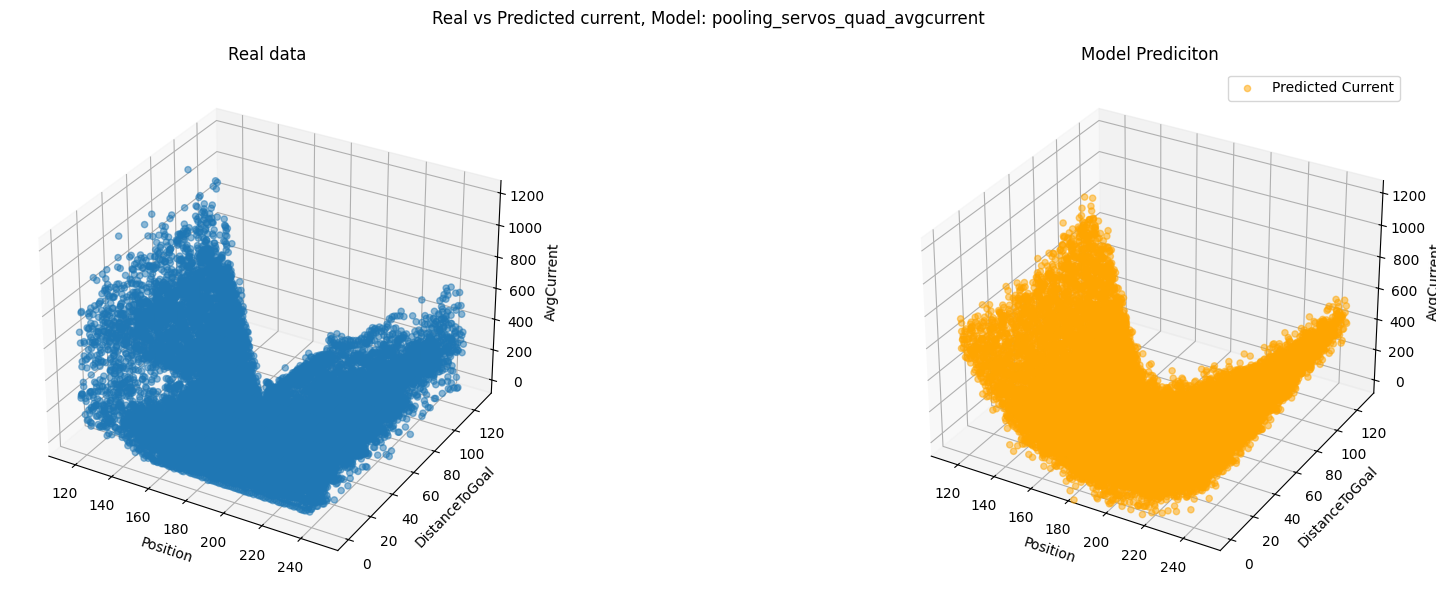

In [31]:
plot_3d_real_vs_predicted(combined_data, ppc_pooling_servos_quad, indep_var=['Position', 'DistanceToGoal'], model_name='pooling_servos_quad_avgcurrent')

In [32]:
with regression_tilt_model:
    pm.compute_log_likelihood(trace_tilt)

with regression_pan_model:
    pm.compute_log_likelihood(trace_pan)

with regression_tilt_model_quadradic:
    pm.compute_log_likelihood(trace_tilt_quad)

with regression_pan_model_quadradic:
    pm.compute_log_likelihood(trace_pan_quad)

with pooling_servos_quad_model:
    pm.compute_log_likelihood(trace_pooling_servos_quad)


Output()

Output()

Output()

Output()

Output()

In [33]:
with pooling_servos_quad_model:
    pm.compute_log_likelihood(trace_pooling_servos_quad)

Output()

ValueError: ['log_likelihood'] group(s) already exists.

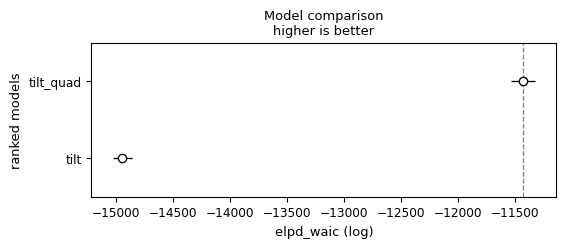

In [34]:
az.plot_compare(tilt_model_comparison)
plt.show()

In [32]:

pan_model_comparison_WAIC = az.compare({'pan': trace_pan, 'pan_quad': trace_pan_quad}, ic='waic')

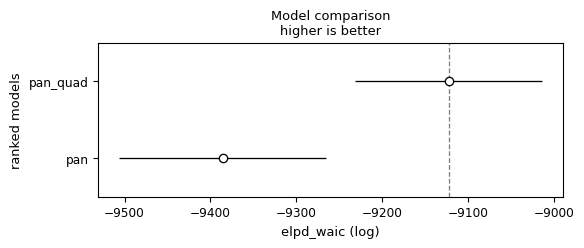

In [59]:
az.plot_compare(pan_model_comparison_WAIC)
plt.show()

In [46]:
## waic of pooling model
pooling_model_WAIC = az.waic(trace_pooling_servos_quad)
pooling_model_WAIC

Computed from 20000 posterior samples and 18373 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -20546.73   153.69
p_waic       16.78        -

In [47]:
ppc_pooling_servos_quad

Inference data with groups:
	> posterior_predictive
	> observed_data

# Models using batched data

In [11]:
batch_size = avg_current_data["NeckPan"].shape[0]  
data = std_all_data.copy()

# Define mini-batches for each variable

tilt_pos_batch = pm.Minibatch(data['tilt_pos'], batch_size=batch_size)
tilt_distance_batch = pm.Minibatch(data['tilt_distance'], batch_size=batch_size)
pan_pos_batch = pm.Minibatch(data['pan_pos'], batch_size=batch_size)
pan_distance_batch = pm.Minibatch(data['pan_distance'], batch_size=batch_size)
tilt_current_batch = pm.Minibatch(data['tilt_current'], batch_size=batch_size)
pan_current_batch = pm.Minibatch(data['pan_current'], batch_size=batch_size)

In [12]:
import os

# Define the file path for saving the trace
trace_file = 'models/trace_tilt_quad_all_std_VI.nc'

# New tilt quadric model using all the data
data = std_all_data.copy()

with pm.Model() as regression_tilt_model_quadradic_all:
    # Priors for the regression coefficients (assuming normal priors)
    beta_position = pm.Normal('beta_position', mu=0, sigma=2)
    beta_distance = pm.Normal('beta_distance', mu=0, sigma=2)
    beta_position2 = pm.Normal('beta_position2', mu=0, sigma=2)
    beta_distance2 = pm.Normal('beta_distance2', mu=0, sigma=2)

    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Prior for the error term
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model equation
    mu = intercept - beta_position * data['tilt_pos'] + beta_distance * data['tilt_distance'] + beta_position2 * data['tilt_pos']**2

    # Likelihood (observed data is normally distributed around mu)
    likelihood = pm.Normal('tilt_current', mu=mu, sigma=sigma, observed=data['tilt_current'])

    if os.path.exists(trace_file):
        # Load the existing trace
        trace_tilt_quad_all = az.from_netcdf(trace_file)
    else:
        # Sample from the posterior
        approx = pm.fit(n=batch_size, method='advi')
        trace_tilt_quad_all = approx.sample(5000)

        # Save the trace to a file
        az.to_netcdf(trace_tilt_quad_all, trace_file)

# Summarize the trace
az.summary(trace_tilt_quad_all)

Output()

Finished [100%]: Average Loss = 9.4199e+05
arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_position   0.781  0.283   0.246    1.307      0.004    0.003    4663.0   
beta_distance   0.100  0.259  -0.373    0.600      0.004    0.003    4993.0   
beta_position2  0.177  0.285  -0.373    0.700      0.004    0.003    5041.0   
beta_distance2 -0.018  1.688  -3.157    3.114      0.024    0.017    5084.0   
intercept      -0.137  0.308  -0.689    0.457      0.004    0.003    5007.0   
sigma           1.002  0.298   0.488    1.549      0.004    0.003    4924.0   

                ess_tail  r_hat  
beta_position     4971.0    NaN  
beta_distance     5025.0    NaN  
beta_position2    4859.0    NaN  
beta_distance2    4821.0    NaN  
intercept         4619.0    NaN  
sigma             5110.0    NaN

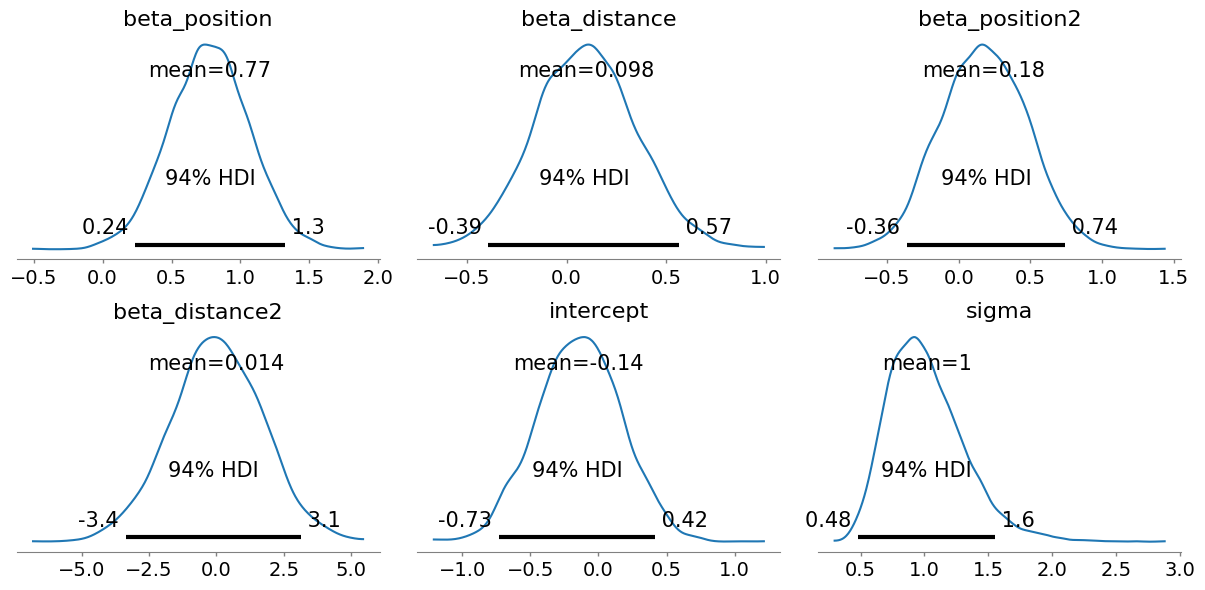

In [12]:
az.plot_posterior(trace_tilt_quad_all, var_names=['beta_position', 'beta_distance', 'beta_position2', 'beta_distance2', 'intercept', 'sigma'], figsize=(12, 6))
plt.tight_layout()
plt.show()

In [13]:
import pymc as pm
import arviz as az
import numpy as np
import gc  # Import garbage collection to manage memory

# Define the number of chunks and chunk size
num_samples = 5000  # Total number of posterior samples you want to use
chunk_size = 1000   # Number of samples per chunk

# Calculate the number of chunks
num_chunks = num_samples // chunk_size

# Loop over chunks to sample posterior predictive
ppc_chunks = []

with regression_tilt_model_quadradic_all:
    for i in range(num_chunks):
        print(f"Starting sampling for chunk {i+1} of {num_chunks}...")

        # Slice the trace manually for each chunk
        trace_chunk = trace_tilt_quad_all.isel(draw=slice(i * chunk_size, (i + 1) * chunk_size))
        
        # Attempt sampling and saving, with diagnostics
        try:
            # Generate posterior predictive samples for this chunk
            ppc_chunk = pm.sample_posterior_predictive(trace_chunk)
            
            # Store each chunk or save it to disk
            ppc_chunks.append(ppc_chunk)
            
            # Save each chunk to disk
            file_path = f'models/ppc_tilt_quad_all_chunk_{i+1}.nc'
            az.to_netcdf(ppc_chunk, file_path)
            print(f"Saved chunk {i+1} to {file_path}")

        except Exception as e:
            print(f"Error encountered during sampling of chunk {i+1}: {e}")
            break  # Exit the loop if there’s an error
        
        # Free up memory after each chunk to ensure we don't hold onto large objects
        del ppc_chunk, trace_chunk  # Delete variables to free memory
        gc.collect()  # Call garbage collection explicitly

        print(f"Finished chunk {i+1}, moving to the next chunk.")
        
print("All chunks sampled and saved.")


Sampling: [tilt_current]


Output()

Starting sampling for chunk 1 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 1 to models/ppc_tilt_quad_all_chunk_1.nc
Finished chunk 1, moving to the next chunk.
Starting sampling for chunk 2 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 2 to models/ppc_tilt_quad_all_chunk_2.nc
Finished chunk 2, moving to the next chunk.
Starting sampling for chunk 3 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 3 to models/ppc_tilt_quad_all_chunk_3.nc
Finished chunk 3, moving to the next chunk.
Starting sampling for chunk 4 of 5...


Sampling: [tilt_current]


Output()

Saved chunk 4 to models/ppc_tilt_quad_all_chunk_4.nc
Finished chunk 4, moving to the next chunk.
Starting sampling for chunk 5 of 5...


In [13]:
subdata = all_data.sample(batch_size)

plot_3d_real_vs_predicted(subdata, ppc_tilt_quad_all, dep_var=["tilt_current", "tilt_current"], indep_var=['tilt_pos', 'tilt_distance'], model_name='tilt_quadradic_batched_VI')

NameError: name 'ppc_tilt_quad_all' is not defined

NameError: name 'ppc_tilt_quad_all' is not defined

In [ ]:
plot_3d_real_vs_predicted(data, ppc_tilt_quad_all, dep_var=["tilt_current", "tilt_current"], indep_var=['tilt_pos', 'tilt_distance'], model_name='tilt_quad_batched')

NameError: name 'ppc_tilt_quad_all' is not defined

In [129]:
trace_file = 'models/trace_tilt_pan_comb_all_std_VI.nc'


with pm.Model() as regression_tilt_pan_model:
    # Priors for regression coefficients
    beta_position_tilt_raw = pm.Normal('beta_position_tilt_raw', mu=0, sigma=1)
    beta_position_tilt = pm.Deterministic('beta_position_tilt_unique', 0 + 1 * beta_position_tilt_raw)
    beta_distance_tilt_raw = pm.Normal('beta_distance_tilt_raw', mu=0, sigma=1)
    beta_distance_tilt = pm.Deterministic('beta_distance_tilt_unique', 0 + 1 * beta_distance_tilt_raw)
    beta_position_tilt2_raw = pm.Normal('beta_position_tilt2_raw', mu=0, sigma=1)
    beta_position_tilt2 = pm.Deterministic('beta_position_tilt2_unique', 0 + 1 * beta_position_tilt2_raw)
    beta_distance_tilt2_raw = pm.Normal('beta_distance_tilt2_raw', mu=0, sigma=1)
    beta_distance_tilt2 = pm.Deterministic('beta_distance_tilt2_unique', 0 + 1 * beta_distance_tilt2_raw)
    beta_position_pan_raw = pm.Normal('beta_position_pan_raw', mu=0, sigma=1)
    beta_position_pan = pm.Deterministic('beta_position_pan_unique', 0 + 1 * beta_position_pan_raw)
    beta_distance_pan_raw = pm.Normal('beta_distance_pan_raw', mu=0, sigma=1)
    beta_distance_pan = pm.Deterministic('beta_distance_pan_unique', 0 + 1 * beta_distance_pan_raw)
    beta_position_pan2_raw = pm.Normal('beta_position_pan2_raw', mu=0, sigma=1)
    beta_position_pan2 = pm.Deterministic('beta_position_pan2_unique', 0 + 1 * beta_position_pan2_raw)
    beta_distance_pan2_raw = pm.Normal('beta_distance_pan2_raw', mu=0, sigma=1)
    beta_distance_pan2 = pm.Deterministic('beta_distance_pan2', 0 + 1 * beta_distance_pan2_raw)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma_tilt = pm.HalfNormal('sigma_tilt', sigma=1)
    sigma_pan = pm.HalfNormal('sigma_pan', sigma=1)

    # Linear model equations with mini-batch variables
    mu_tilt = (intercept + beta_position_tilt * tilt_pos_batch + beta_distance_tilt * tilt_distance_batch + 
               beta_position_tilt2 * tilt_pos_batch**2  + 
               beta_distance_tilt2 * tilt_distance_batch**2)
               
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma_tilt, observed=tilt_current_batch)

    mu_pan = (intercept + beta_position_pan * pan_pos_batch + beta_distance_pan * pan_distance_batch + 
              beta_position_pan2 * pan_pos_batch**2 + beta_distance_pan2 * pan_distance_batch**2 + 
              beta_position_tilt * tilt_pos_batch + beta_position_tilt2 * tilt_pos_batch**2)
    
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma_pan, observed=pan_current_batch)

    if os.path.exists(trace_file):
        # Load existing trace
        trace_tilt_pan = az.from_netcdf(trace_file)
    else:
        # Fit with ADVI and save the trace
        approx = pm.fit(30000, method="fullrank_advi", progressbar=True)
        trace_tilt_pan = approx.sample(1000)
        #trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan, trace_file)

az.summary(trace_tilt_pan) 


Output()

Finished [100%]: Average Loss = 14,218
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position_tilt_raw     -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_raw      0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_raw    -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_raw    -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_raw       0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_raw       0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_raw      0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2_raw     -0.000  0.045  -0.084    0.083      0.001    0.001   
intercept                   0.005  0.052  -0.089    0.104      0.002    0.001   
sigma_tilt                  1.001  0.015   0.976    1.030      0.001    0.000   
sigma_pan                   1.000  0.022   0.957    1.040      0.001    0.001   
beta_position_tilt_unique  -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_unique   0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_unique -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_unique -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_unique    0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_unique    0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_unique   0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2         -0.000  0.045  -0.084    0.083      0.001    0.001   

                            ess_bulk  ess_tail  r_hat  
beta_position_tilt_raw         959.0     860.0    NaN  
beta_distance_tilt_raw         969.0     946.0    NaN  
beta_position_tilt2_raw        836.0     851.0    NaN  
beta_distance_tilt2_raw        980.0     722.0    NaN  
beta_position_pan_raw          966.0     981.0    NaN  
beta_distance_pan_raw         1001.0     793.0    NaN  
beta_position_pan2_raw         890.0     843.0    NaN  
beta_distance_pan2_raw         953.0     837.0    NaN  
intercept                      813.0     794.0    NaN  
sigma_tilt                     787.0     775.0    NaN  
sigma_pan                      878.0     919.0    NaN  
beta_position_tilt_unique      959.0     860.0    NaN  
beta_distance_tilt_unique      969.0     946.0    NaN  
beta_position_tilt2_unique     836.0     851.0    NaN  
beta_distance_tilt2_unique     980.0     722.0    NaN  
beta_position_pan_unique       966.0     981.0    NaN  
beta_distance_pan_unique      1001.0     793.0    NaN  
beta_position_pan2_unique      890.0     843.0    NaN  
beta_distance_pan2             953.0     837.0    NaN

In [130]:
with regression_tilt_pan_model:
    ppc_tilt_pan = pm.sample_posterior_predictive(trace_tilt_pan)

Sampling: [PanCurrent, TiltCurrent]


Output()

In [ ]:
trace_file = 'models/trace_tilt_pan_comb_all_std_VI.nc'


with pm.Model() as regression_tilt_pan_model:
    # Priors for regression coefficients
    beta_position_tilt_raw = pm.Normal('beta_position_tilt_raw', mu=0, sigma=1)
    beta_position_tilt = pm.Deterministic('beta_position_tilt_unique', 0 + 1 * beta_position_tilt_raw)
    beta_distance_tilt_raw = pm.Normal('beta_distance_tilt_raw', mu=0, sigma=1)
    beta_distance_tilt = pm.Deterministic('beta_distance_tilt_unique', 0 + 1 * beta_distance_tilt_raw)
    beta_position_tilt2_raw = pm.Normal('beta_position_tilt2_raw', mu=0, sigma=1)
    beta_position_tilt2 = pm.Deterministic('beta_position_tilt2_unique', 0 + 1 * beta_position_tilt2_raw)
    beta_distance_tilt2_raw = pm.Normal('beta_distance_tilt2_raw', mu=0, sigma=1)
    beta_distance_tilt2 = pm.Deterministic('beta_distance_tilt2_unique', 0 + 1 * beta_distance_tilt2_raw)
    beta_position_pan_raw = pm.Normal('beta_position_pan_raw', mu=0, sigma=1)
    beta_position_pan = pm.Deterministic('beta_position_pan_unique', 0 + 1 * beta_position_pan_raw)
    beta_distance_pan_raw = pm.Normal('beta_distance_pan_raw', mu=0, sigma=1)
    beta_distance_pan = pm.Deterministic('beta_distance_pan_unique', 0 + 1 * beta_distance_pan_raw)
    beta_position_pan2_raw = pm.Normal('beta_position_pan2_raw', mu=0, sigma=1)
    beta_position_pan2 = pm.Deterministic('beta_position_pan2_unique', 0 + 1 * beta_position_pan2_raw)
    beta_distance_pan2_raw = pm.Normal('beta_distance_pan2_raw', mu=0, sigma=1)
    beta_distance_pan2 = pm.Deterministic('beta_distance_pan2', 0 + 1 * beta_distance_pan2_raw)
    
    # Prior for the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)
    
    # Prior for the error term
    sigma_tilt = pm.HalfNormal('sigma_tilt', sigma=1)
    sigma_pan = pm.HalfNormal('sigma_pan', sigma=1)

    # Linear model equations with mini-batch variables
    mu_tilt = (intercept + beta_position_tilt * tilt_pos_batch + beta_distance_tilt * tilt_distance_batch + 
               beta_position_tilt2 * tilt_pos_batch**2  + 
               beta_distance_tilt2 * tilt_distance_batch**2)
               
    likelihood_tilt = pm.Normal('TiltCurrent', mu=mu_tilt, sigma=sigma_tilt, observed=tilt_current_batch)

    mu_pan = (intercept + beta_position_pan * pan_pos_batch + beta_distance_pan * pan_distance_batch + 
              beta_position_pan2 * pan_pos_batch**2 + beta_distance_pan2 * pan_distance_batch**2 + 
              beta_position_tilt * tilt_pos_batch + beta_position_tilt2 * tilt_pos_batch**2)
    
    likelihood_pan = pm.Normal('PanCurrent', mu=mu_pan, sigma=sigma_pan, observed=pan_current_batch)

    if os.path.exists(trace_file):
        # Load existing trace
        trace_tilt_pan = az.from_netcdf(trace_file)
    else:
        # Fit with ADVI and save the trace
        approx = pm.fit(30000, method="fullrank_advi", progressbar=True)
        trace_tilt_pan = approx.sample(1000)
        #trace_tilt_pan = pm.sample(3000, tune=1000, return_inferencedata=True, cores=4)
        az.to_netcdf(trace_tilt_pan, trace_file)

az.summary(trace_tilt_pan) 


Output()

Finished [100%]: Average Loss = 14,218
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_position_tilt_raw     -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_raw      0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_raw    -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_raw    -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_raw       0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_raw       0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_raw      0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2_raw     -0.000  0.045  -0.084    0.083      0.001    0.001   
intercept                   0.005  0.052  -0.089    0.104      0.002    0.001   
sigma_tilt                  1.001  0.015   0.976    1.030      0.001    0.000   
sigma_pan                   1.000  0.022   0.957    1.040      0.001    0.001   
beta_position_tilt_unique  -0.002  0.017  -0.035    0.027      0.001    0.000   
beta_distance_tilt_unique   0.001  0.018  -0.033    0.035      0.001    0.000   
beta_position_tilt2_unique -0.002  0.043  -0.082    0.078      0.001    0.001   
beta_distance_tilt2_unique -0.004  0.025  -0.050    0.046      0.001    0.001   
beta_position_pan_unique    0.003  0.020  -0.033    0.041      0.001    0.000   
beta_distance_pan_unique    0.006  0.197  -0.366    0.356      0.006    0.004   
beta_position_pan2_unique   0.002  0.030  -0.055    0.056      0.001    0.001   
beta_distance_pan2         -0.000  0.045  -0.084    0.083      0.001    0.001   

                            ess_bulk  ess_tail  r_hat  
beta_position_tilt_raw         959.0     860.0    NaN  
beta_distance_tilt_raw         969.0     946.0    NaN  
beta_position_tilt2_raw        836.0     851.0    NaN  
beta_distance_tilt2_raw        980.0     722.0    NaN  
beta_position_pan_raw          966.0     981.0    NaN  
beta_distance_pan_raw         1001.0     793.0    NaN  
beta_position_pan2_raw         890.0     843.0    NaN  
beta_distance_pan2_raw         953.0     837.0    NaN  
intercept                      813.0     794.0    NaN  
sigma_tilt                     787.0     775.0    NaN  
sigma_pan                      878.0     919.0    NaN  
beta_position_tilt_unique      959.0     860.0    NaN  
beta_distance_tilt_unique      969.0     946.0    NaN  
beta_position_tilt2_unique     836.0     851.0    NaN  
beta_distance_tilt2_unique     980.0     722.0    NaN  
beta_position_pan_unique       966.0     981.0    NaN  
beta_distance_pan_unique      1001.0     793.0    NaN  
beta_position_pan2_unique      890.0     843.0    NaN  
beta_distance_pan2             953.0     837.0    NaN

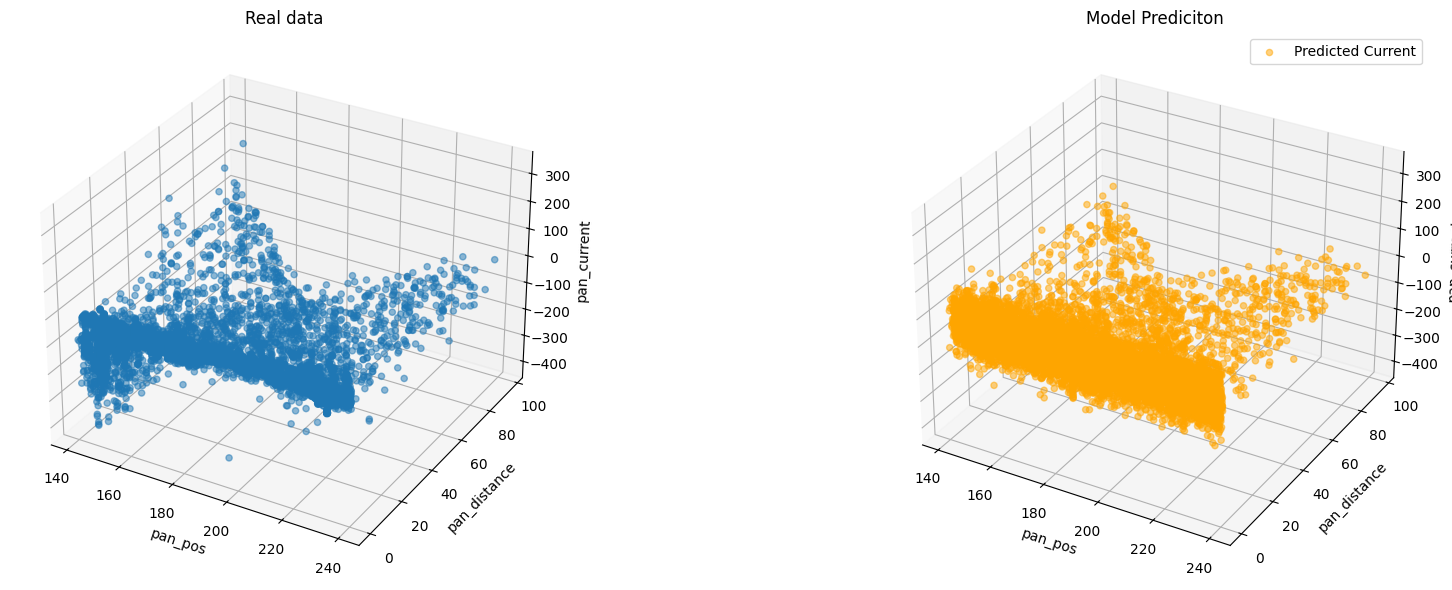

In [95]:
plot_3d_real_vs_predicted(subdata, ppc_tilt_pan, dep_var=["pan_current", "PanCurrent"], indep_var=['pan_pos', 'pan_distance'], model_name='TiltPan_batched-pan')

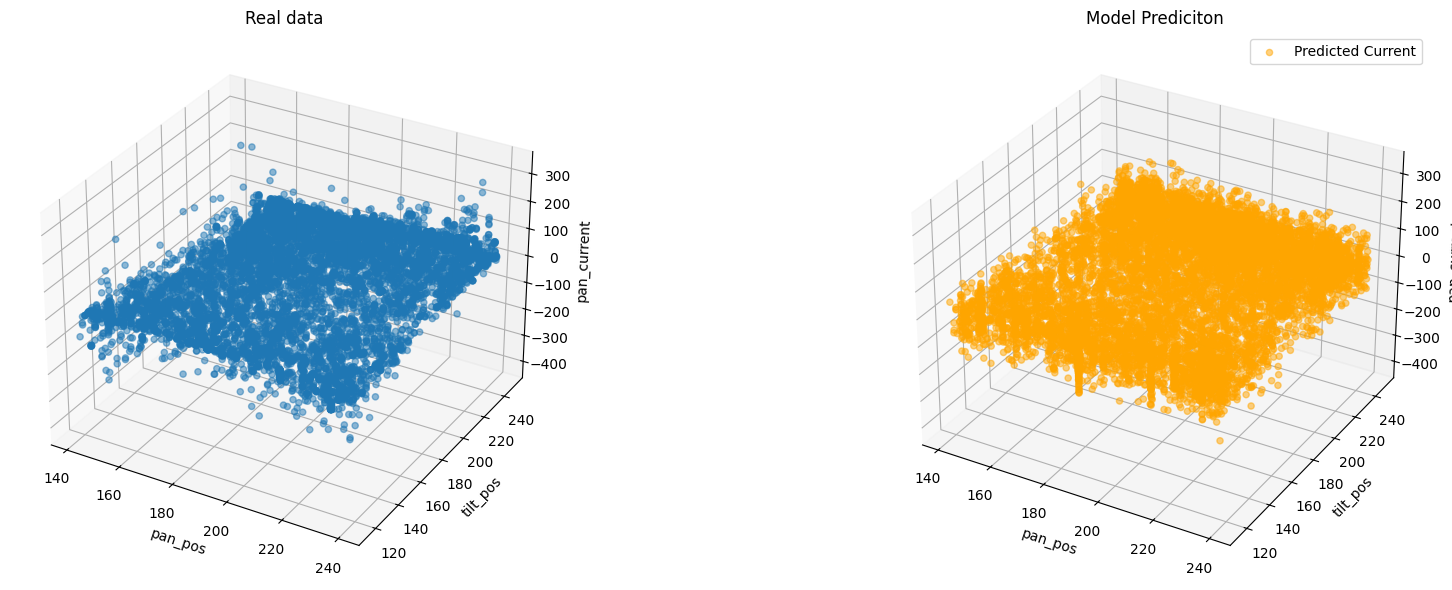

In [97]:
plot_3d_real_vs_predicted(subdata, ppc_tilt_pan, dep_var=["pan_current", "PanCurrent"], indep_var=['pan_pos', 'tilt_pos'], model_name='TiltPan_batched-pan')

In [113]:
all_data

tilt_pos  pan_pos  tilt_current  pan_current  gyro_x  gyro_y  gyro_z  \
0         176.35   192.35          0.00         0.00   -0.46    0.49   -0.43   
1         176.35   192.35          0.00         0.00   -0.07    0.58    0.00   
2         176.35   192.35        -23.52       -23.52   -0.03    0.55    0.64   
3         176.44   192.35        -26.88       -26.88   -1.10    0.67    0.52   
4         176.35   192.35        -26.88       -26.88   -0.46   -0.09    1.12   
...          ...      ...           ...          ...     ...     ...     ...   
700862    180.57   180.04       -151.20       -10.08   12.86   71.64   -2.23   
700863    180.04   180.13       -124.32        -6.72   13.41   72.36   -2.16   
700864    179.52   180.04        -53.76       -10.08   13.93   73.57   -1.83   
700865    178.90   180.04        -77.28        -6.72   13.77   73.44   -1.19   
700866    178.37   180.13        268.80       -10.08   12.68   69.99   -0.13   

        accel_x  accel_y  accel_z  tilt_distance  pan_distance  
0          0.00     0.00     0.00          17.58          6.42  
1          0.23    -0.03    -0.94          17.58          6.42  
2          0.23    -0.03    -0.94          17.58          6.42  
3          0.23    -0.03    -0.94          17.67          6.42  
4          0.23    -0.03    -0.94          17.58          6.42  
...         ...      ...      ...            ...           ...  
700862     0.05    -0.04    -0.93           2.20          0.09  
700863     0.06    -0.04    -0.93           1.67          0.00  
700864     0.08    -0.04    -0.93           1.15          0.09  
700865     0.09    -0.04    -0.93           0.53          0.09  
700866     0.09    -0.04    -0.93           0.00          0.00  

[700867 rows x 12 columns]